# Exploring the Weather in Athens

In this assignment I will show some usefull diagrams about the weather in Athens over a period of more than 50 years.

---

> Dimitris Mazarakis, Student <br />
> AM: 8180064  <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> t8180064@aueb.gr

First of all I start by makign all the necessary imports.

In [1]:
import numpy as np

import calendar
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

Here I set the style of the graphs

In [2]:
sns.set(palette='deep', color_codes=True)

I read the files with the two datasets from data folder and create two datasets the old_data which has data from all the period (1955-2020), and the new_data which has data only for the period 2010-2019

# Q1

In [3]:
data_filename_old = "data/old_weather_data.csv"
data_filename_new = "data/new_weather_data.csv"

old_data = pd.read_csv(data_filename_old)
    
new_data = pd.read_csv(data_filename_new)

Here I add columns names in the new_data dataset and I create a new dataset with only the necessary columns for the assignment, same for the old_data dataset.

In [4]:
new_data.columns =["DATE", "AVGT", "TMAX", "TMIN", "HUM1","HUM2","HUM3","PA1","PA2","PA3","RAIN","WIND1","WIND2","WIND3",]

new_basic_info=new_data.drop(['HUM1', 'HUM2', 'HUM3', 'PA1', 'PA2', 'PA3', 'WIND1', 'WIND2', 'WIND3'], axis=1)

old_basic_info=old_data.drop(['STATION'], axis=1)

In order to merge the two datasets I will need to have the same columns so here I chang the order of the columns in new_basic_info table

In [5]:
new_basic_info.columns=["DATE", "TAVG", "TMAX", "TMIN", "PRCP"]

Adding a column which indicates if data are from the old or the new dataset

In [6]:
new_basic_info['NEW'] = True
old_basic_info['NEW'] = False

Merging the two tables in one

In [7]:
frames = [old_basic_info, new_basic_info]

all_data = pd.concat(frames)

Sorting all_data by date and droping all the duplicate dates
Source code that helped me: https://stackoverflow.com/questions/52395820/drop-duplicates-keep-most-recent-date-pandas-dataframe

In [8]:
all_data = all_data.sort_values('DATE')
all_days = all_data.loc[(all_data['DATE'].duplicated(keep=False) == False) | (all_data['NEW'] == False), :]

Here I convert the DATE column to datetime.

In [9]:
all_days['DATE'] = pd.to_datetime(all_days['DATE'])

# Q2

Here I replace some '---' values that occured to TAVG column with NaN and I convert TAVG column to numeric.

In [10]:
all_days['TAVG'] = all_days['TAVG'].replace('---',np.NaN)
all_days['TAVG'] = pd.to_numeric(all_days['TAVG'])

Saving to summer_months dataset only the values for the summer months. then removing '---' from TAVG column and then converting date to datetime type 

In [11]:
summer_months = all_days[(all_days['DATE'].dt.month == 6) | (all_days['DATE'].dt.month == 7) | (all_days['DATE'].dt.month == 8)]

Here I create the table mean_per_year that contains the temperature for every year fot the summenr months.

In [12]:
summer_months['TAVG'] = pd.to_numeric(summer_months['TAVG'])
mean_per_year  = summer_months.groupby(summer_months['DATE'].dt.year)['TAVG'].mean()

mean_per_year  = mean_per_year .reset_index()

I find the baseline for the period 1974-199 for the summer months and store it to summer_mean variable.

In [13]:
summer_mean = mean_per_year[(mean_per_year['DATE'] >= 1974) & (mean_per_year['DATE'] <= 1999)].TAVG.mean()

Here I find the difference between average temperature per year and the baseline temperature for the 25 years.

In [14]:
mean_per_year.TAVG = mean_per_year.TAVG - summer_mean

In [15]:
summer_diviation = mean_per_year

Finding 10 year rolling average. </br>
Source that helped: https://stackoverflow.com/questions/49684734/dataframe-moving-average-with-rolling-mean-and-shift-while-ignoring-nan

In [16]:
summer_diviation['Rolling_avg'] = summer_diviation.TAVG.rolling(window=10,min_periods=1).mean()

Here I create the graph for the Q2. The positive column of the summer_diviation table shows if a temperature value is above the baseline in order to have different colors in the graph. The last line with the set_xticks function, seperates the years to decades in the x axis.

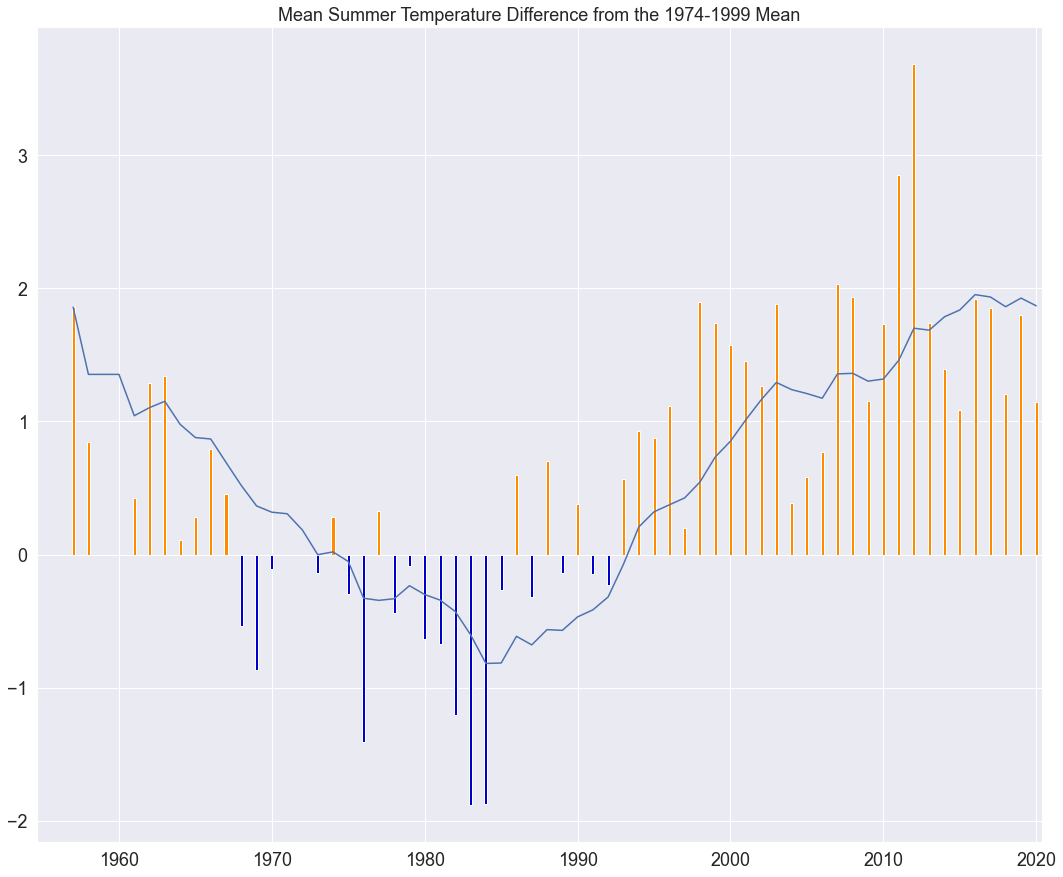

In [17]:
summer_diviation['positive'] = summer_diviation['TAVG'] > 0

diagram = pd.Series(summer_diviation['TAVG'].values,summer_diviation['DATE']).plot( kind="bar",figsize=(18, 15), width=0.2, color=summer_diviation.positive.map({True: 'darkorange', False: 'mediumblue'})) # We use the indices of x and the values of y

pd.Series(summer_diviation['Rolling_avg'].values).plot(figsize=(18, 15))
#plt.style.use('seaborn')
plt.title('Mean Summer Temperature Difference from the 1974-1999 Mean',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('') # Label of the x axis

diagram.set_xticks(np.arange(5, 74, 10));

As we can see on the graph, in the 1970-2000 period the average temperature for each year does not exceed by a lot the baseline but instead it is lower in some years. That is happening because the baseline is for the period 1974-1999 and the hot summers after 1990 balance with the colder summers in 70s and 80s. After 1994 the summers are getting hotter and hotter, here we can mention that in 1995 a big fire took place in Penteli mountain so this could caused this rising course. Also, again at 2007 a big fire took place in Parnitha mountain and we can see that in 2008 and 2009 an almost two degrees increment. For the year 2012 I found an [article](https://www.tanea.gr/2012/08/21/greece/to-pio-kayto-kalokairi-edw-kai-115-xronia/) that said that it was one of the hottest summers in the last 115 years and we can see it on the graph because the bar exceeds the 3 degrees difference from the baseline and it is the highest bar.

# Q3

# Note </br> 
With the code in the comments I can delete the leap year dates which are 17 for the years 1955-2020 and by that the diagram in Q3 will not have that drop in the last days of the year (near 30-12).

Here I find all the leap dates and I remove them from the dataset because they change the graph. </br>
Source code: https://stackoverflow.com/questions/34966422/remove-leap-year-day-from-pandas-dataframe/34966636

In [18]:
'''
def is_leap_and_29Feb(s):
    date = s['DATE']
    return (date.dt.year % 4 == 0) & ((date.dt.year % 100 != 0) | (date.dt.year % 400 == 0)) & (date.dt.month == 2) & (date.dt.day == 29)

mask = is_leap_and_29Feb(all_days)
all_days = all_days.loc[~mask]
'''

"\ndef is_leap_and_29Feb(s):\n    date = s['DATE']\n    return (date.dt.year % 4 == 0) & ((date.dt.year % 100 != 0) | (date.dt.year % 400 == 0)) & (date.dt.month == 2) & (date.dt.day == 29)\n\nmask = is_leap_and_29Feb(all_days)\nall_days = all_days.loc[~mask]\n"

Firstly, I add column to the dataset that shows the day and month of each date in order to know which the day in a year.

In [19]:
all_days['day_and_month'] = all_days['DATE'].dt.strftime('%m-%d')

Here I calculate the 30 days rolling average and store it to the Rolling_avg column and then I create a new table with the average temperature of each year

In [20]:
all_days['Rolling_avg'] = all_days.TAVG.rolling(window=30).mean()

Finding 30 days rolling average for the period 1974 to 1999 in order to draw the black line in the graph below.

In [21]:
black_line = all_days[(all_days['DATE'] >"1973-12-31") & (all_days['DATE'] < "2000-1-1")]
black_line['Rolling_avg'] = black_line.TAVG.rolling(window=30).mean()

Here I plot the diagram for the q3 and I use sns.lineplot. I setted hue in order to draw a line for each year.

Source that helped me: https://earthly.dev/blog/plotting-rainfall-data-with-python-and-matplotlib/

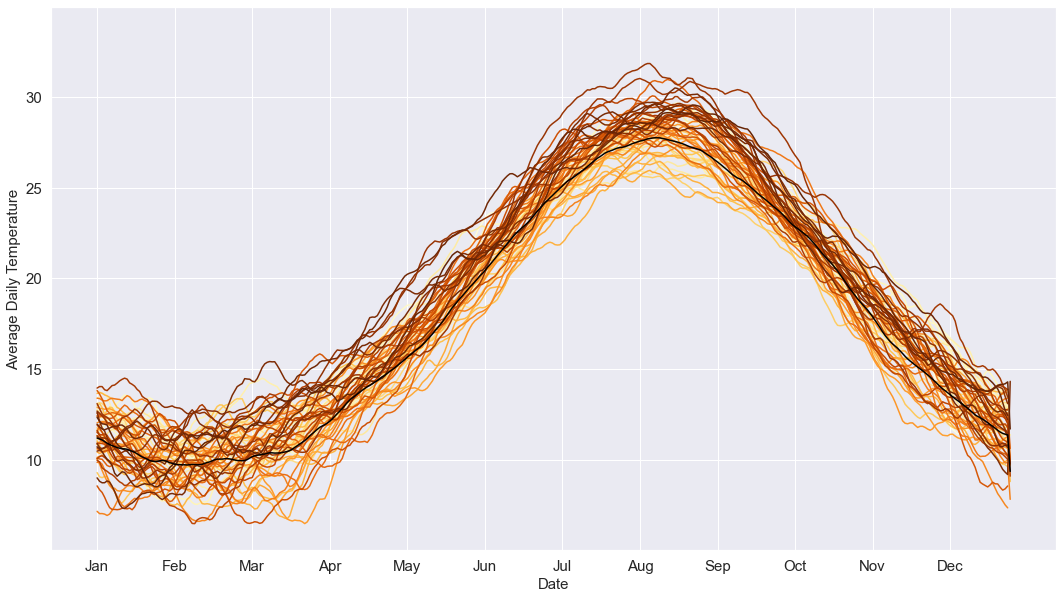

In [22]:
plt.figure(figsize=(18, 10))

q3 = sns.lineplot(x=all_days['day_and_month'],y="Rolling_avg", data=all_days, hue=all_days['DATE'].dt.year, ci=None, palette= "YlOrBr", legend=False)
q3 = sns.lineplot(x=black_line['day_and_month'],y="Rolling_avg", data=black_line, ci=None, color= "black")

months_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date',fontsize=15) # Label of the x axis
plt.ylabel('Average Daily Temperature',fontsize=15) # Label of the y axis

q3.set_xticks(np.arange(0,365,31))
q3.set_xticklabels(months_list);
q3.set_ylim(5, 35)
q3.set_yticks(np.arange(10,35,5));

In order to create the black line I calculated the average temperature for every day in a year for all the years in the period 1974-1999 and this is baseline. Every orange line is a different year from 1955 to 2020, the more darker orange the more newer year. We can observe that the darker orange lines are more likely to be above the baseline than the lighter orange lines. That means that the average temperature for every day in a year is getting hotter and hotter as time passes. We can also see that the heat peak is happening at August and the cold peak at February.

# Q4

Finding mean temperature for every day in a year for the baseline period 1974 to 1999.

In [23]:
baseline_daily_mean = black_line.groupby(black_line['day_and_month']).mean()
baseline_daily_mean = baseline_daily_mean.reset_index()

Finding if one date has a NaN value in the TAVG column

In [24]:
all_days['is_nan'] = all_days['TAVG'].isna()

Merging all_days and baseline_daily_mean tables in order to have an expected value for every date.

In [25]:
merged = pd.merge(all_days, baseline_daily_mean[['day_and_month','TAVG']], on='day_and_month')

Here I store which dates had an extreme heat event.

In [26]:
merged['extreme'] = np.where((merged['TAVG_x']>1.1*merged['TAVG_y']) & ((merged['TAVG_x'].notna())) ,True,False)

I add the count column in order to count the dates in each year.

In [27]:
all_days['count'] = 1

Firstly, I find all extreme events per year and after that I find the observations per year and then I store to q4_diagram table the divition between the observations and the events_per_year.

In [37]:
events_per_year = merged.groupby(merged['DATE'].dt.year)['extreme'].sum()

nan_tavg_per_year = all_days.groupby(all_days['DATE'].dt.year)['is_nan'].sum()
observations_per_year = all_days.groupby(all_days['DATE'].dt.year)['count'].sum()
observations_per_year = observations_per_year - nan_tavg_per_year

q4_diagram = events_per_year/observations_per_year
q4_diagram = q4_diagram.reset_index()

DATE
1955      0
1956      0
1957     52
1958    130
1959      0
       ... 
2016    159
2017    170
2018    173
2019    163
2020    168
Name: extreme, Length: 66, dtype: int64

Here I store the baseline(grey line) for the period 1974-1999 and check which days of the year exceed the baseline.

In [29]:
q4_diagram.columns= ['DATE','EVENTS_PERCENTAGE']

baseline_q4 = q4_diagram[(q4_diagram['DATE'] > 1973) & (q4_diagram['DATE'] < 2000)]['EVENTS_PERCENTAGE'].mean()

q4_diagram['positive'] = q4_diagram['EVENTS_PERCENTAGE'] > baseline_q4

Finally, I draw the requested diagram. </br>
For the horizontal grey line I saw this source :https://stackoverflow.com/questions/51622120/how-to-draw-horizontal-lines-for-each-line-in-pandas-plot

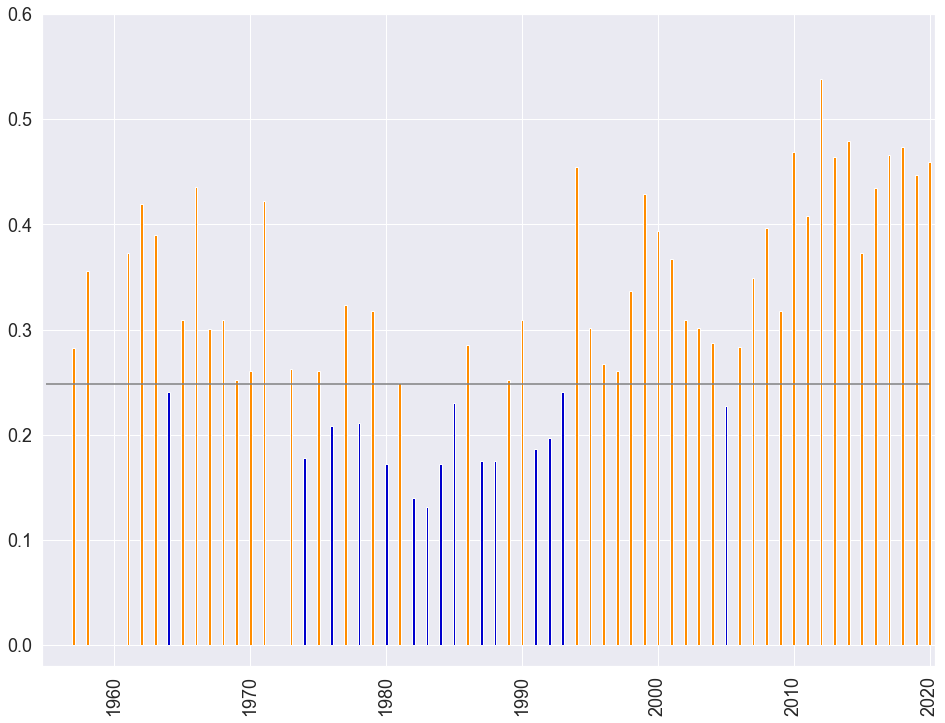

In [30]:
d = pd.Series(q4_diagram['EVENTS_PERCENTAGE'].values,q4_diagram['DATE']).plot( kind="bar",figsize=(16, 12), width=0.2, color=q4_diagram.positive.map({True: 'darkorange', False: 'mediumblue'})) # We use the indices of x and the values of y

d.hlines(baseline_q4, d.get_xticks().min(), d.get_xticks().max(), color='grey')
plt.xlabel('') # Label of the x axis

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
d.set_ylim([-0.02,0.6])
d.set_xticks(np.arange(5, 74, 10));

With a quick look we can observe that after 1995 extreme heat events tend to increase as years go by and after 2010 we have almost 0.4 percent more extreme heat events per year. In the period 1974 to 1994 the extreme heat events are near the baseline, because the baseline is calculated within this period so it make sense, and only few exceed the baseline. For the year 1995 which risies up pretty abruptly we can say again that the fire at Penteli mountain could be the cause.

# Q5

Finding overall rainfall in every year.

In [31]:
overall_rain = all_days.groupby(all_days['DATE'].dt.year)['PRCP'].sum()

Add a column to show if the day was rainy or not.

In [32]:
all_days['rainy'] = np.where(all_days['PRCP']>0,True,False)

Finding rainy days per year.

In [33]:
rainy_days_per_year = all_days.groupby(all_days['DATE'].dt.year)['rainy'].sum()

Dividing rainfall with rainy days per year.

In [34]:
rain_indicator = overall_rain/rainy_days_per_year
rain_indicator = rain_indicator.reset_index()
rain_indicator.columns = ['DATE', 'RAIN_PER_DAY']


Calculating the 10 years rolling average

In [35]:
rain_indicator['Rolling_avg'] = rain_indicator.RAIN_PER_DAY.rolling(window=10,min_periods=1).mean()

And finally, here I draw the graph for q5.

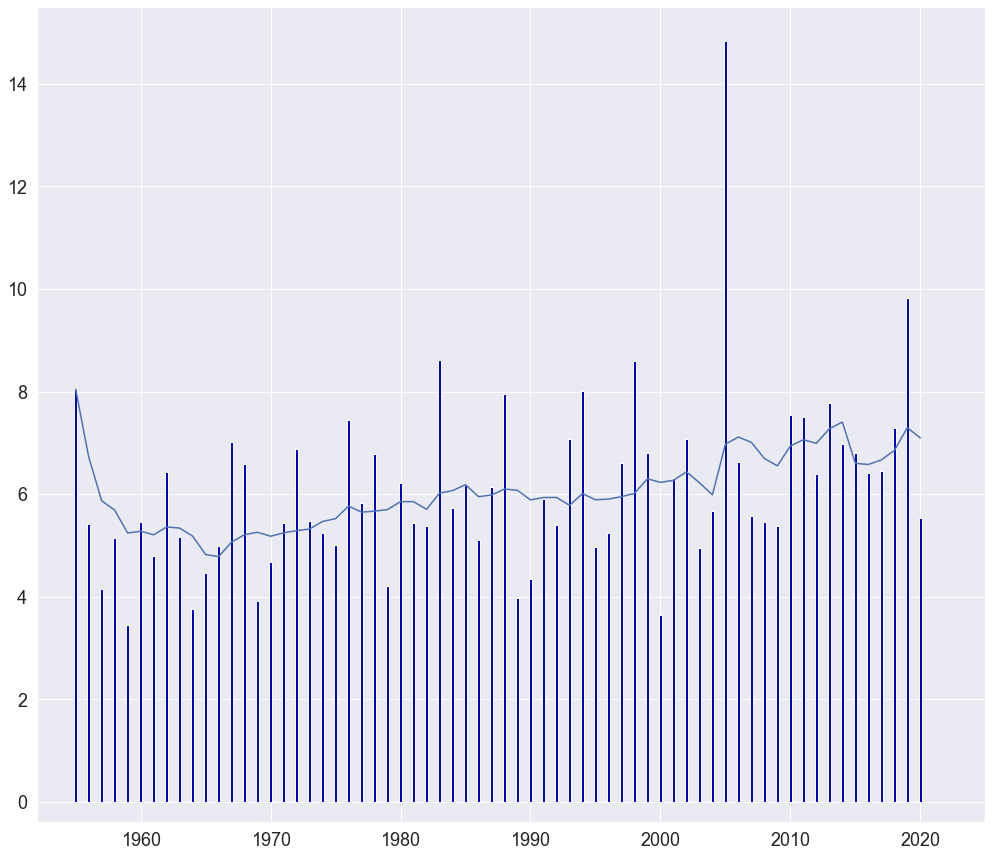

In [36]:
d=pd.Series(rain_indicator['RAIN_PER_DAY'].values,rain_indicator['DATE']).plot( kind="bar",figsize=(18, 15), width=0.2, color='mediumblue') # We use the indices of x and the values of y

pd.Series(rain_indicator['Rolling_avg'].values).plot(figsize=(17, 15))

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('',fontsize=16) # Label of the x axis
d.set_ylim([-0.4,15.5])
d.set_xlim([-3,70])
d.set_xticks(np.arange(5, 74, 10));

In this graph we can see that the precipitation in a year is slowly increasing within the years, we can see it by watching the blue line which is the 10 years rolling average.  We can see that in 2006 the ratio of rainfall divided by the rainy days was the highest from all the 66 years by far.